<a href="https://colab.research.google.com/github/osgeokr/GEE-PAM-Book/blob/main/3%EC%9E%A5_%EC%9C%84%EC%84%B1%EA%B8%B0%EB%B0%98_%EC%8B%9D%EC%83%9D%EB%B3%80%ED%99%94_%EB%B6%84%EC%84%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3장. 위성기반 식생변화 분석

## 3.1. 설악산국립공원 식생지수 분석

In [1]:
import ee
import geemap
import pandas as pd
import matplotlib.pyplot as plt
from ipyleaflet import TileLayer
from google.colab import files

# Earth Engine 인증
ee.Authenticate()

# Earth Engine 초기화
ee.Initialize(project='ee-foss4g')

### 3.1.1. 설악산국립공원 경계 추출

In [2]:
# 설악산국립공원 경계 추출
wdpa = ee.FeatureCollection("WCMC/WDPA/current/polygons")
seoraksan = wdpa.filter(ee.Filter.eq('WDPAID', 768))

# 선택된 보호지역 이름 확인
wdpa_name = seoraksan.first().get('NAME').getInfo()
print("Name:", wdpa_name)

Name: Seoraksan


In [7]:
# Vworld 배경지도 객체
vworld_base = TileLayer(
    url='https://xdworld.vworld.kr/2d/Base/service/{z}/{x}/{y}.png',
    name='Vworld Base', attribution='Vworld',
)

# 설악산국립공원 경계
m = geemap.Map(width="800px", height="400px")
m.add_layer(vworld_base)
m.addLayer(seoraksan, {'color': 'green'}, wdpa_name)
m.centerObject(seoraksan, 11)
m

Map(center=[38.13576002082187, 128.41324042116062], controls=(WidgetControl(options=['position', 'transparent_…

### 3.1.2. Sentinel-2 이미지 선택 및 필터링

In [8]:
def mask_s2_clouds(image):
    # QA(Quality Assurance) 밴드 사용, S2에서 구름 마스킹
    qa = image.select('QA60')

    # 비트 10은 구름(clouds), 11은 성층운(cirrus)
    cloud_bit_mask = 1 << 10
    cirrus_bit_mask = 1 << 11

    # 구름과 성층운이 0이면 맑은 상태로 간주함.
    mask = (
        qa.bitwiseAnd(cloud_bit_mask)
        .eq(0)
        .And(qa.bitwiseAnd(cirrus_bit_mask).eq(0))
    )

    return image.updateMask(mask).divide(10000) # 스케일링

In [9]:
# Sentinel-2 이미지 선택 및 필터링
s2_images = (
    ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")
    .filterDate("2024-01-01", "2024-01-31")
    .filterBounds(seoraksan)
    # 구름이 5% 미만인 이미지 필터링
    .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", 5))
    .map(mask_s2_clouds)
)

# 이미지 컬렉션의 이미지 개수 확인
image_count = s2_images.size()

# 이미지 개수 출력
print("Image count:", image_count.getInfo())

Image count: 4


In [ ]:
# 중간값 이미지 계산
s2_image = s2_images.median()

In [11]:
# TCC
vis_params = {
    'min': 0.0,
    'max': 0.3,
    'bands': ['B4', 'B3', 'B2'],
}

m = geemap.Map(width="800px", height="400px")
m.add_layer(s2_image, vis_params, 'TCC')
m.centerObject(seoraksan, 11)
m

Map(center=[38.13576002082187, 128.41324042116062], controls=(WidgetControl(options=['position', 'transparent_…

In [12]:
#FCC
vis_params = {
    'min': 0.0,
    'max': 0.3,
    'bands': ['B8', 'B4', 'B3'],
}

m = geemap.Map(width="800px", height="400px")
m.add_layer(s2_image, vis_params, 'FCC')
m.centerObject(seoraksan, 11)
m

Map(center=[38.13576002082187, 128.41324042116062], controls=(WidgetControl(options=['position', 'transparent_…

### 3.1.3. 국립공원 경계 내에서 NDVI 계산 및 통계치 산출

In [13]:
# NDVI 계산: (NIR - Red) / (NIR + Red)
ndvi = s2_image.normalizedDifference(['B8', 'B4'])

In [16]:
# NDVI 색상 팔레트 정의
ndvi_palette = [
    'FE8374',  # 낮은 NDVI - 갈색
    'FED976',  # 낮은-중간 NDVI - 밝은 녹색
    'CAE23C',  # 중간 NDVI - 녹색
    '98B718',  # 중간-높은 NDVI - 진한 녹색
    '059033',  # 높은 NDVI - 매우 진한 녹색
]

# Vworld 하이브리드지도 객체
vworld_hybrid = TileLayer(
    url='https://xdworld.vworld.kr/2d/Hybrid/service/{z}/{x}/{y}.png',
    name='Vworld Hybrid',
    attribution='Vworld',
)

m = geemap.Map(width="800px", height="400px")
m.add_layer(ndvi, {'min': 0, 'max': 0.5, 'palette': ndvi_palette}, 'NDVI')
m.add_layer(vworld_hybrid)
m.centerObject(seoraksan, 11)
m

Map(center=[38.13576002082187, 128.41324042116062], controls=(WidgetControl(options=['position', 'transparent_…

In [17]:
# NDVI 통계치 계산 (최소값, 평균, 중간값, 최대값, 표준편차)
stats = ndvi.reduceRegion(
    reducer=ee.Reducer.min()
    .combine(reducer2=ee.Reducer.mean(), sharedInputs=True)
    .combine(reducer2=ee.Reducer.median(), sharedInputs=True)
    .combine(reducer2=ee.Reducer.max(), sharedInputs=True)
    .combine(reducer2=ee.Reducer.stdDev(), sharedInputs=True),
    geometry=seoraksan.geometry(),
    scale=10,
    maxPixels=1e9,
)

# 통계치 결과를 DataFrame으로 변환
df_stats = pd.DataFrame(
    [stats.getInfo()],
    columns=["nd_min", "nd_mean", "nd_median", "nd_max", "nd_stdDev"],
    index=["Seoraksan"],
)
df_stats.columns = ["Min", "Mean", "Median", "Max", "StdDev"]
df_stats

,Min,Mean,Median,Max,StdDev
Seoraksan,-0.352342,0.237857,0.183589,1,0.197171


In [18]:
# DataFrame을 CSV 파일로 저장하기
df_stats.to_csv('df_stats.csv', index=True)
files.download('df_stats.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 3.2. 설악산생물권보전지역 산림손실 분석

### 3.2.1. 설악산 생물권보전지역 경계 추출

In [19]:
# 설악산 생물권보전지역 경계 추출
wdpa = ee.FeatureCollection("WCMC/WDPA/current/polygons")
seorak = wdpa.filter(ee.Filter.eq('WDPAID', 5085))

# 선택된 보호지역의 이름 확인
wdpa_name = seorak.first().get('NAME').getInfo()
print("Name:", wdpa_name)

Name: Mount Sorak


In [20]:
# 1: 외곽선의 픽셀 값, 2: 외곽선의 두께(픽셀 단위)
wdpa_raster = ee.Image().paint(seorak, 1, 2)

# 시각화 파라미터 설정
wdpa_vis = {
    'palette': ['#FFFF00'], # Yellow 색상 적용
    'opacity': 1
}

### 3.2.2. 산림변화 데이터셋 사용

In [21]:
# Hansen Global Forest Change v1.10 (2000-2022) 데이터셋
gfc = ee.Image('UMD/hansen/global_forest_change_2022_v1_10')

# 수관피복 시각화 파라미터
tree_cover_vis = {
    'bands': ['treecover2000'],
    'min': 0,
    'max': 100,
    'palette': ['black', 'green']
}

# 산림손실 시각화 파라미터
tree_loss_vis = {
    'bands': ['lossyear'],
    'min': 0,
    'max': 22,
    'palette': ['yellow', 'red']
}

In [23]:
# gfc 레이어 추가
m = geemap.Map(width="800px", height="400px")
m.addLayer(gfc, tree_cover_vis, 'tree cover')
m.addLayer(gfc, tree_loss_vis, 'tree loss year')
m.addLayer(wdpa_raster, wdpa_vis, wdpa_name)
m.add_layer(vworld_hybrid)
m.centerObject(seorak, 10) # 지도의 중심 설정
m # 지도 객체 출력

Map(center=[38.121201950409365, 128.4049622752154], controls=(WidgetControl(options=['position', 'transparent_…

### 3.2.3. 산림손실 면적 계산 및 시각화

In [ ]:
# 산림손실 이미지
loss_image = gfc.select(['loss'])
area_image = loss_image.multiply(ee.Image.pixelArea())

# 설악산 BR 내 산림손실 면적 합산
stats = area_image.reduceRegion(
    reducer=ee.Reducer.sum(),
    geometry=seorak.geometry(),
    scale=30,
    maxPixels=1e9,
)

# 산림손실 면적 출력
loss_area = stats.get('loss').getInfo()
print(f"산림손실 면적: {loss_area:.2f}m²")

산림손실 면적: 17368422.44m²


In [24]:
# 산림손실연도 이미지
lossyear_image = gfc.select(['lossyear'])

# 2001-2022년 산림손실 면적 계산
years = range(1, 23)
loss_areas = []

for year in years:
    # 해당 연도의 산림손실 픽셀 선택
    yearly_loss = lossyear_image.eq(year)

    # 산림손실 면적 계산
    area_image = yearly_loss.multiply(ee.Image.pixelArea())
    stats = area_image.reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=seorak.geometry(),
        scale=30,
        maxPixels=1e9,
    )

    # 연도별 손실 면적을 리스트에 추가 (단위: 제곱미터)
    loss_area = stats.getInfo()['lossyear']
    loss_areas.append(loss_area)

# 연도와 손실 면적을 데이터프레임으로 변환
df = pd.DataFrame({
    'Year': range(2001, 2023),
    'Loss_Area_m2': loss_areas
})

df['Loss_Area_ha'] = df['Loss_Area_m2'] / 10000
df.head(1)

,Year,Loss_Area_m2,Loss_Area_ha
0,2001,200388.253457,20.038825


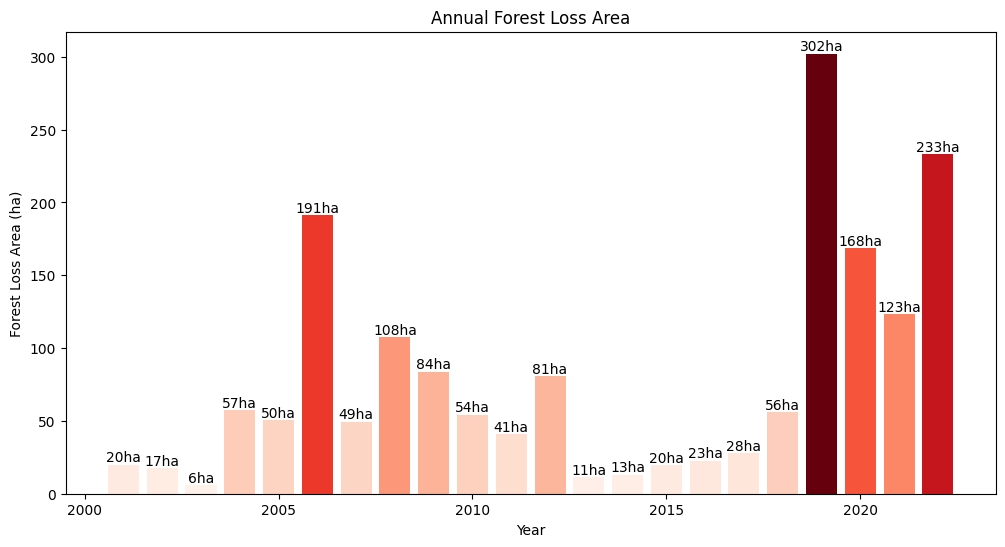

In [27]:
# 연도별 산림손실 면적 막대 그래프 생성
fig, ax = plt.subplots(figsize=(12, 6))
colors = plt.cm.Reds(df['Loss_Area_ha'] / df['Loss_Area_ha'].max())
bars = ax.bar(df['Year'], df['Loss_Area_ha'], color=colors)

# 막대 위에 헥타르 단위로 면적 표시
for bar, area_ha in zip(bars, df['Loss_Area_ha']):
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, f'{area_ha:.0f}ha', va='bottom', ha='center', color='black')

# 레이블 설정
ax.set_xlabel('Year')
ax.set_ylabel('Forest Loss Area (ha)')
ax.set_title('Annual Forest Loss Area')

# 차트를 이미지로 저장
plt.savefig('forest_loss_area_colored.png', dpi=100)
plt.show()